## Read concatatenated 2D field variables and make contour plot

- Relevant information summarized on the [PINACES RCE website](https://portal.nersc.gov/cfs/m1867/pinacles_docs/site/fields2d/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr  #better to have dask so that xarray uses it automatically


### file pathnames and description of the simulation

In [2]:
pcase = 'rce' #parent case name
icase = 'test_1km_01' #sub casename
#archive 2D output directory in the collaboration account scratch
indir= '/pscratch/sd/w/wcmca1/PINACLES/rce/1km/archive/fields2d'
infile = 'cat_01d_00h_00m-46d_02h_00m.nc' #concatenated file



In [3]:

tdimname = 'time'
chunksize=24
dtsec = 600

dt = np.timedelta64(dtsec, 's')
nt_per_day = 24*3600/dtsec

In [23]:
ds = xr.open_dataset((indir + '/' + infile)).squeeze()

nrec = ds.dims['record']
nx = ds.dims['X']
ny = ds.dims['Y']

dx = 1000.0 #m
dy = dx

x = np.arange(dx*0.5,dx*nx+dx*0.5,dx)
y = x

### adjust time record dimension & variable
the original output file does not have "unlimited" attribute for the time record
NCO's concatenatation created another dimension called "record". Change this dimension name to "time"

In [24]:
#create a time record array to be used as the time variable
trec = np.arange(0,nrec*dtsec,dtsec)
trecnp = np.arange(0,nrec*dtsec,dtsec,dtype='datetime64[s]') #also as numpy datetime64 
trecnp_ns = trecnp.astype('datetime64[ns]')

In [27]:
#manupirate concatenated dimensions
ds= ds.rename({'time': 'onerecord'})
ds = ds.rename_dims({'record': 'time'})
ds = ds.assign_coords({'time': trecnp_ns})
ds = ds.reset_coords(names='onerecord',drop = True)

### name of the variable to plot and time stamp to plot

In [31]:
invarname = 'LW_UP_TOA' 
plottime = '1970-02-10T00:00'
#invar = ds[invarname].sel(time='1970-01-01T00:10')

In [32]:
invar = ds[invarname].sel(time=plottime)
npdim = invar.shape


In [35]:
#plot setting
iyear = 0 #actual year used by PINACLES; numpy time record uses default 1970

unitf = 1.0
unitshift = 0.0
pvmin = None
pvmax = None
icmap = 'jet'
px = x/1000 #km
py = y/1000 #km
iunits = ''

if(invarname == 'LW_UP_TOA'):
    iunits = "W/m2"
    pvmin = 120
    pvmax = 270
    

figformat = 'pdf'  #figure format
figdir = '/pscratch/sd/w/wcmca1/PINACLES/rce/1km/archive/figs/test' #figure path

### do loop animation for specified days


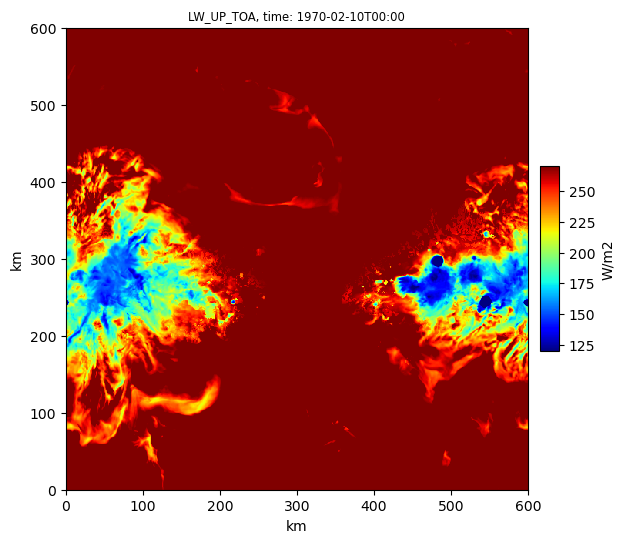

In [37]:
save_fig = False

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
iplot = invar*unitf + unitshift
ctf = ax.pcolormesh( px, py, iplot, shading='nearest',
            vmin = pvmin, vmax = pvmax,cmap = icmap, rasterized=True) 
_= ax.set_aspect('equal')

cbar = fig.colorbar(ctf,shrink = 0.4, pad=0.02, aspect=10,label = iunits, ax=ax)
_= ax.set_xlabel('km')
_= ax.set_ylabel('km')
_= ax.set_title((invarname + ', time: ' + plottime), fontsize='small')

if(save_fig):
    figname = (figdir + '/cont_' + invarname + '_' + ptime + '.' + figformat)
    plt.savefig(figname, dpi=300, bbox_inches='tight')
else:
    plt.show()

#trying to free memory
fig.clear() #this does free memory: https://stackoverflow.com/a/55834853/20647995
plt.close(fig) #another option for not plotting interactively
del iplot
del ctf,ax,fig
        